# Explore the synthetic datasets

This notebook introduces you to two datasets that have been provided with this repository, to accompany our example of the modelling of emergency demand for beds:
- `ed_visits.csv` 
- `inpatient_arrivals.csv`

This notebook does some data exploration by plotting charts of all relevant variables in each dataset. 

The inpatient_arrivals dataset contains arrival times of all patients who visited the UCLH Emergency Department (ED) and the Same Day Emergency Care (SDEC) unit, over the period of the data, and were later admitted. It includes their sex, child status (whether adult or child), and a column to assign each one to training, validation and test sets.

The ed_visits database contains a set of snapshots of patients who visited the ED and SDEC over the period of the data, including both admitted and discharged patients. It uses the following concepts:

- visit: a single visit to the ED which may end in admission or discharge
- prediction times: the times in the day at which predictions are to be made (eg 06:00, 09:30, 12:00, 15:30, 22:00)
- visit snapshots: snapshots of visits observed at the prediction times; a single visit may have multiple visit snapshots

Each visit snapshot includes information about the patient's age, arrival method, location in the ED or SDEC and previous locations in the same visit, vital signs, triage scores, lab orders and results. It also has summarising variables that record how many times an event like measuring heart rate has taken place. 

See the [data dictionaries](../data-dictionaries/) for detailed information about each variable, including its range, mean and standard deviation (for continuous variables) or frequency. For the `ed_visits.csv` dataset, additional columns in the data dictionaries show the same information for the admitted and non-admitted patients. These additional columns have been used to generate the synthetic data. 

## Learn more about the data

Dr Zella King recorded a webinar to demonstrate how we converted data from the UCLH Electronic Health Record in a form suitable for this modelling. If you click on the image below, the video will open at the point where she provides detail about the datasets 

<a href="https://www.youtube.com/watch?v=ha_zckz3_rU&t=262s" target="_blank">
    <img src="img/thumbnail_NHSR_webinar.jpg" alt="Link to webinar on how to turn your EHR data into predictions of demand for emergency beds" width="600"/>
</a>



## Set up the notebook environment


In [2]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [3]:
# set project root manually 
%env PROJECT_ROOT=/Users/zellaking/Repos/patientflow

env: PROJECT_ROOT=/Users/zellaking/Repos/patientflow


In [4]:
from patientflow.load import set_project_root
project_root = set_project_root()



Project root is /Users/zellaking/Repos/patientflow


## Load parameters and set file paths

Parameters are set in config.json and (for UCLH implementation in config-uclh.yaml). You can change these for your own purposes. I'll talk more about the role of each parameter as it becomes relevant. Here we are loading the pre-defned training, validation and test set dates.  

For more information about parameters and file paths, see notebook [4a_Predict_probability_of_admission_from_ED.ipynb](4a_Predict_probability_of_admission_from_ED.ipynb)

In [5]:
from patientflow.load import set_file_paths, load_config_file

# indicate whether the notebook is being run locally for UCLH or with public datasets
uclh = False

# set file paths
if uclh:
    data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        project_root, 
        data_folder_name='data-uclh',
        config_path='config-uclh.yaml')
else:
    data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        project_root, 
        data_folder_name='data-synthetic')

# load parameters
params = load_config_file(config_path)
start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]


Configuration will be loaded from: /Users/zellaking/Repos/patientflow/config.yaml
Data files will be loaded from: /Users/zellaking/Repos/patientflow/data-synthetic
Trained models will be saved to: /Users/zellaking/Repos/patientflow/trained-models/synthetic
Images will be saved to: /Users/zellaking/Repos/patientflow/trained-models/synthetic/media


## Load data


Here we are loading the synthetic data that has been created from the distributions of real patient data. The method used to create the synthetic data was to generate sample values following the statistics reported in the [data dictionaries](../data-dictionaries/). 

In [44]:
import pandas as pd
from patientflow.load import load_data

ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

inpatient_arrivals = load_data(data_file_path, 
                    file_name='inpatient_arrivals.csv', 
                    index_column = 'snapshot_id',)

ed_visits.head()

Index column 'snapshot_id' not found in dataframe


,snapshot_date,prediction_time,visit_number,training_validation_test,random_number,elapsed_los,sex,age_group,arrival_method,current_location_type,...,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,latest_lab_results_alb,latest_lab_results_htrt,final_sequence,is_admitted,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
324871,2031-03-01,"(6, 0)",1,train,40230,20495,F,35-44,Ambulance,majors,...,NaN,138.0,NaN,7.0,NaN,NaN,NaN,[],False,NaN
325949,2031-03-01,"(15, 30)",2,train,46697,27609,F,55-64,Walk-in,utc,...,NaN,NaN,NaN,7.0,NaN,49.0,NaN,[],False,NaN
326292,2031-03-01,"(12, 0)",3,train,38383,12783,F,75-102,Walk-in,sdec,...,NaN,NaN,NaN,NaN,NaN,NaN,205.0,[paeds],False,NaN
326837,2031-03-01,"(15, 30)",4,train,24424,20474,F,18-24,Walk-in,majors,...,2.5,NaN,NaN,NaN,NaN,NaN,NaN,[],False,NaN
326862,2031-03-01,"(15, 30)",5,train,16075,9743,M,45-54,Walk-in,sdec,...,NaN,NaN,6.0,NaN,NaN,NaN,NaN,[],False,NaN


# A note about training, validation and test sets

Each snapshot in visits, and each observation in arrivals has already been assigned to a training, validation or test set. This is good practice in modelling, as a set of data kept separate from the training process can be used to evaluate the predictions on independent data. The validation set is used for tuning the Machine Model used to predict probability of admission. 

The allocation into each set has been done chronologically. 

In [45]:
# Show the training, validation and test set dates
print(f'\nTraining set starts {start_training_set} and ends on {start_validation_set - pd.Timedelta(days=1)} inclusive')
print(f'Validation set starts on {start_validation_set} and ends on {start_test_set - pd.Timedelta(days=1)} inclusive' )
print(f'Test set starts on {start_test_set} and ends on {end_test_set- pd.Timedelta(days=1)} inclusive' )


Training set starts 2031-03-01 and ends on 2031-08-31 inclusive
Validation set starts on 2031-09-01 and ends on 2031-09-30 inclusive
Test set starts on 2031-10-01 and ends on 2031-12-31 inclusive


The training set is the majority of the dataset, with a small validation set and a larger test set

In [46]:
print('\nTraining, validation and test set split in ed_visits dataset')
print(ed_visits.training_validation_test.value_counts())

print('\nTraining, validation and test set split in arrivals dataset')
print(inpatient_arrivals.training_validation_test.value_counts())


Training, validation and test set split in ed_visits dataset
training_validation_test
train    50444
test     22087
valid     7182
Name: count, dtype: int64

Training, validation and test set split in arrivals dataset
training_validation_test
train    7729
test     3665
valid    1242
Name: count, dtype: int64


## Explore visits dataset

Note that each snapshot has a date and a prediction time formatted separately. 

In [47]:
ed_visits.head(10)

,snapshot_date,prediction_time,visit_number,training_validation_test,random_number,elapsed_los,sex,age_group,arrival_method,current_location_type,...,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,latest_lab_results_alb,latest_lab_results_htrt,final_sequence,is_admitted,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
324871,2031-03-01,"(6, 0)",1,train,40230,20495,F,35-44,Ambulance,majors,...,NaN,138.0,NaN,7.0,NaN,NaN,NaN,[],False,NaN
325949,2031-03-01,"(15, 30)",2,train,46697,27609,F,55-64,Walk-in,utc,...,NaN,NaN,NaN,7.0,NaN,49.0,NaN,[],False,NaN
326292,2031-03-01,"(12, 0)",3,train,38383,12783,F,75-102,Walk-in,sdec,...,NaN,NaN,NaN,NaN,NaN,NaN,205.0,[paeds],False,NaN
326837,2031-03-01,"(15, 30)",4,train,24424,20474,F,18-24,Walk-in,majors,...,2.5,NaN,NaN,NaN,NaN,NaN,NaN,[],False,NaN
326862,2031-03-01,"(15, 30)",5,train,16075,9743,M,45-54,Walk-in,sdec,...,NaN,NaN,6.0,NaN,NaN,NaN,NaN,[],False,NaN
327142,2031-03-01,"(15, 30)",6,train,58375,20304,F,0-17,Ambulance,utc,...,NaN,NaN,6.0,NaN,13.0,NaN,NaN,[],False,NaN
327971,2031-03-01,"(9, 30)",7,train,52382,2343,M,45-54,Walk-in,majors,...,NaN,NaN,8.0,7.0,NaN,NaN,NaN,[acute],True,surgical
328005,2031-03-01,"(22, 0)",8,train,63725,27761,M,55-64,Ambulance,majors,...,1.3,NaN,NaN,NaN,19.0,NaN,NaN,[neuro],True,surgical
328764,2031-03-01,"(15, 30)",9,train,11630,18684,F,55-64,Walk-in,majors,...,NaN,139.0,NaN,7.0,NaN,NaN,NaN,[],False,NaN


### Grouping of columns in ED visits dataset

The ED visits dataset contains variables of different types. 

For convenience, to help with the output below function called `get_dict_cols()` wiis used to organise the output below into different groups.

In [48]:
from patientflow.load import get_dict_cols
dict_cols = get_dict_cols(ed_visits)

for key, value in dict_cols.items():
    print(f"\nColumns in group called {key}:")
    print(value)




Columns in group called not used in training:
['snapshot_id', 'snapshot_date', 'prediction_time', 'visit_number', 'training_validation_test', 'random_number']

Columns in group called arrival and demographic:
['elapsed_los', 'sex', 'age_group', 'age_on_arrival', 'arrival_method']

Columns in group called summary:
['num_obs', 'num_obs_events', 'num_obs_types', 'num_lab_batteries_ordered']

Columns in group called location:
['current_location_type', 'total_locations_visited', 'visited_majors', 'visited_otf', 'visited_paeds', 'visited_rat', 'visited_resus', 'visited_sdec', 'visited_sdec_waiting', 'visited_unknown', 'visited_utc', 'visited_waiting']

Columns in group called observations:
['num_obs_blood_pressure', 'num_obs_pulse', 'num_obs_air_or_oxygen', 'num_obs_glasgow_coma_scale_best_motor_response', 'num_obs_level_of_consciousness', 'num_obs_news_score_result', 'num_obs_manchester_triage_acuity', 'num_obs_objective_pain_score', 'num_obs_subjective_pain_score', 'num_obs_temperature', 

In [49]:
# Function to convert boolean columns to text values "true" or "false" - used for plotting format
def bool_to_text(df):
    bool_cols = df.select_dtypes(include='bool').columns.drop('is_admitted')
    for col in bool_cols:
        df[col] = df[col].apply(lambda x: 'true' if x else 'false')
    return df

# Apply the function
ed_visits = bool_to_text(ed_visits)

# temporarily add a is_admitted column to arrivals 
inpatient_arrivals['is_admitted'] = True
inpatient_arrivals = bool_to_text(inpatient_arrivals)

As some variables are ordinal, we create a dictionary to record this and use below where needed. 

In [50]:
ordinal_mappings = {
    "age_group": [
        "0-17",
        "18-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "65-74",
        "75-102",
    ],
    "latest_obs_manchester_triage_acuity": ["Blue", "Green", "Yellow", "Orange", "Red"],
    "latest_obs_objective_pain_score": [
        r"Nil",
        r"Mild",
        r"Moderate",
        r"Severe\E\Very Severe",
    ],
            "latest_obs_level_of_consciousness": [
        "A", #alert
        "C", #confused
        "V", #voice - responds to voice stimulus
        "P", #pain - responds to pain stimulus
        "U" #unconscious - no response to pain or voice stimulus
    ]
}



### Arrival and demographic variables

Here we import a function called plot_distributions to provide a convenient short way of requesting each plot.

In [51]:
from patientflow.viz.distribution_plots import plot_distributions



#### Elapsed Length of Stay

Both admitted and not admitted visits appear to have a long tail of visits lasting more than 24 hours. Note that the data extraction that has created this dataset has not included any snapshots after 3 days. 


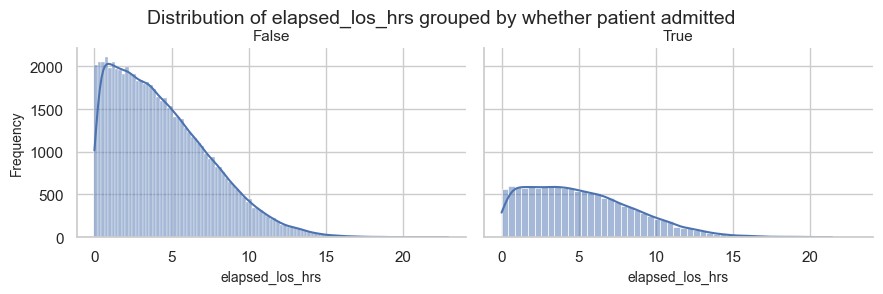

In [87]:
ed_visits['elapsed_los_hrs'] = ed_visits['elapsed_los']/3600
plot_distributions(ed_visits, 'elapsed_los_hrs', 'is_admitted', 'whether patient admitted', plot_type='both')

Plotting only the visits of less than 24 hours, we can see a clear picture of activity aimed at getting people discharged within four hours

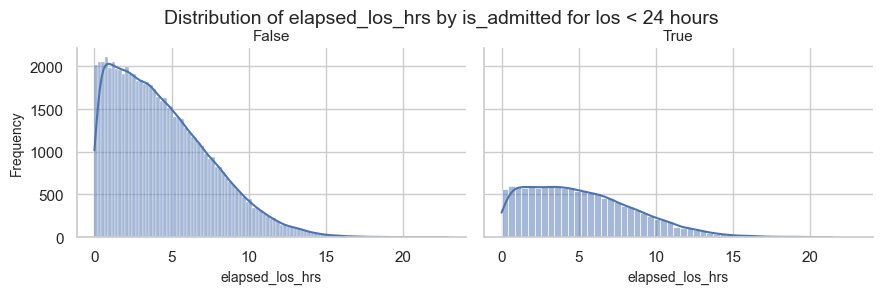

In [88]:
plot_distributions(ed_visits[ed_visits.elapsed_los_hrs < 24], 'elapsed_los_hrs', 'is_admitted', 'whether patient admitted', plot_type='both', title = 'Distribution of elapsed_los_hrs by is_admitted for los < 24 hours')

From below, we can see that the long tail of longer visits is more numerous for discharged than for admitted patients 

In [89]:
if ed_visits[ed_visits.elapsed_los_hrs >= 24].shape[0] > 0:
    plot_distributions(ed_visits[ed_visits.elapsed_los_hrs >= 24], 'elapsed_los_hrs', 'is_admitted', 'whether patient admitted', plot_type='both', title = 'Distribution of elapsed_los_hrs by is_admitted for los >= 24 hours')

#### Sex, age group and arrival method

The charts below show a different distribution between admitted and not admitted patients for both age group (more older people are admitted) and arrival method (most walk-ins are discharged).

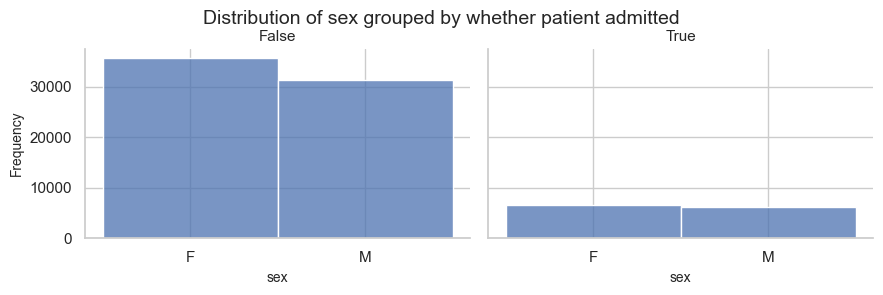

In [90]:
plot_distributions(ed_visits, 'sex', 'is_admitted', 'whether patient admitted', plot_type='hist')

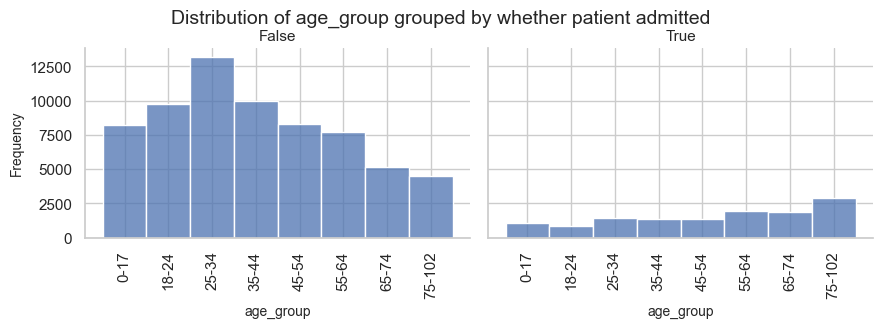

In [91]:
if 'age_group' in ed_visits.columns:
    plot_distributions(ed_visits, 'age_group', 'is_admitted', 'whether patient admitted', plot_type='hist', ordinal_order=ordinal_mappings['age_group'], rotate_x_labels = True)
else:
    plot_distributions(ed_visits, 'age_on_arrival', 'is_admitted', 'whether patient admitted', plot_type='hist')


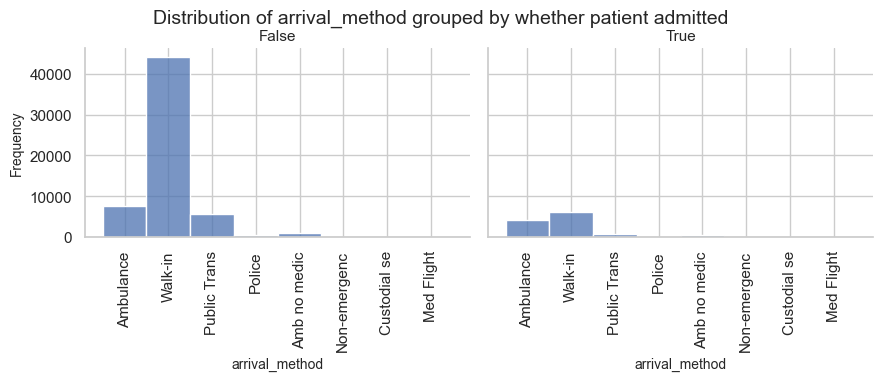

In [92]:
plot_distributions(ed_visits, 'arrival_method', 'is_admitted', 'whether patient admitted', plot_type='hist', rotate_x_labels = True)

### Summary variables

The summary variables have counts of the following, up to the moment of the snapshot
* the number of observations recorded
* the number of events at which observations were recorded (if heart rate and respiratory rate have the same timestamp in the original data, this is one event)
* the number of different types of observations (heart rate and respiratory would be two types)
* the number of lab test batteries ordered

In [93]:
dict_cols['summary']

['num_obs', 'num_obs_events', 'num_obs_types', 'num_lab_batteries_ordered']

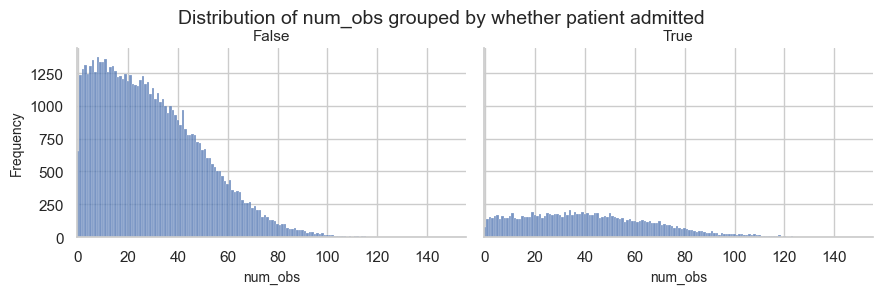

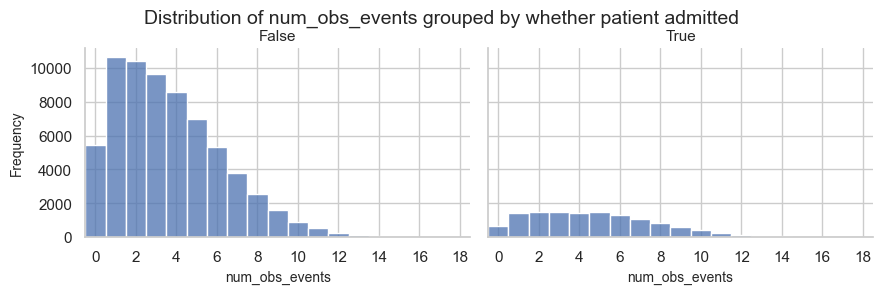

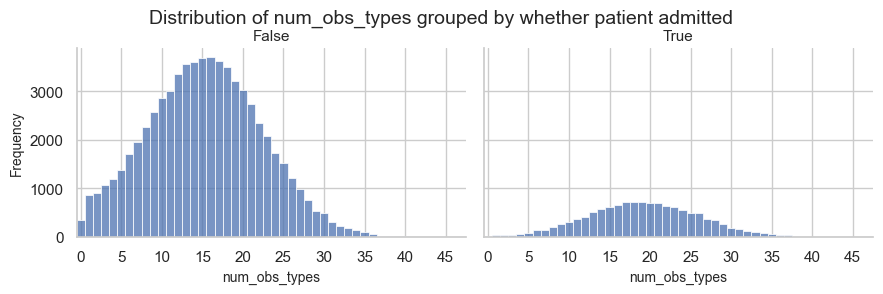

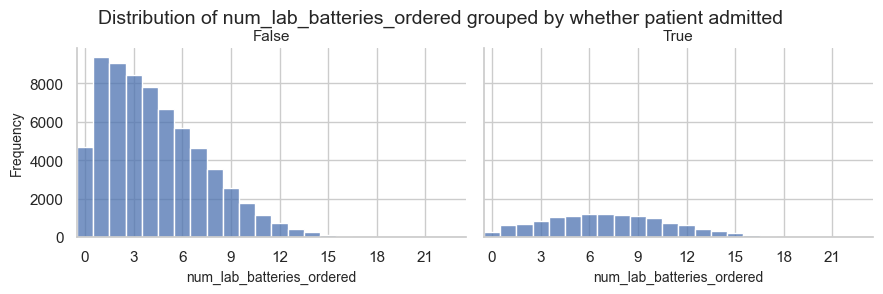

In [94]:
for col_name in dict_cols['summary']:
    plot_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist', is_discrete = True)

In [95]:
print(ed_visits.num_obs.max())
print(ed_visits.num_obs_events.max())

155
18


### Location variables

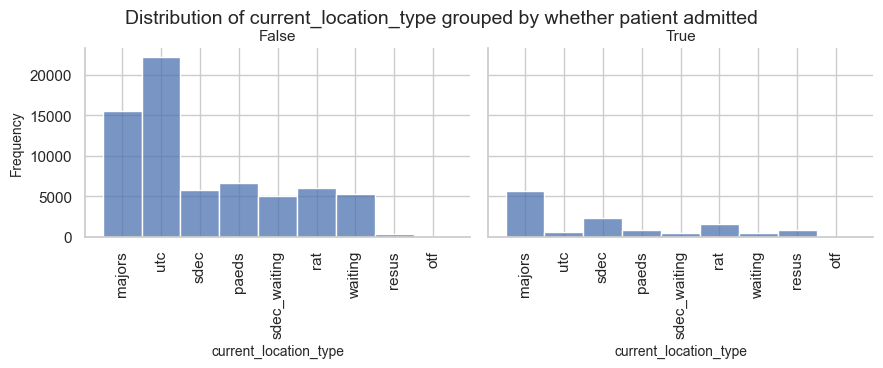

In [96]:
plot_distributions(ed_visits, 'current_location_type', 'is_admitted', 'whether patient admitted', plot_type='hist', rotate_x_labels = True)

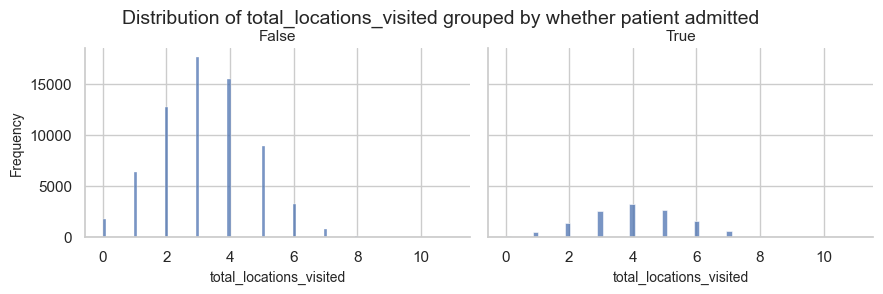

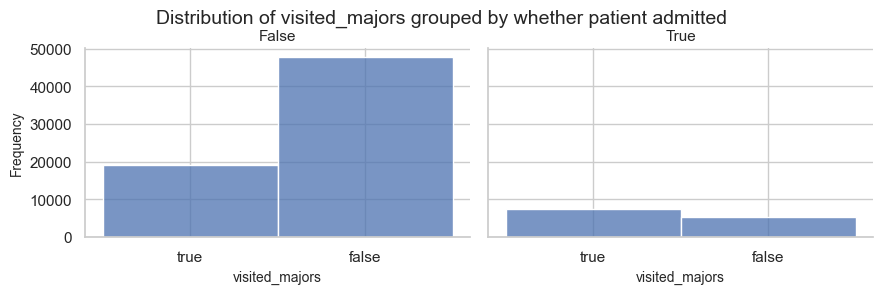

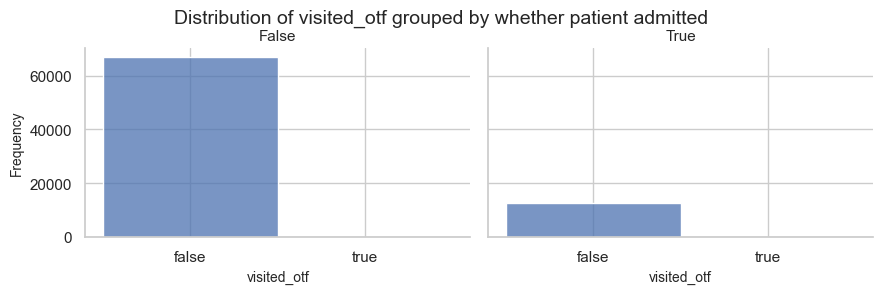

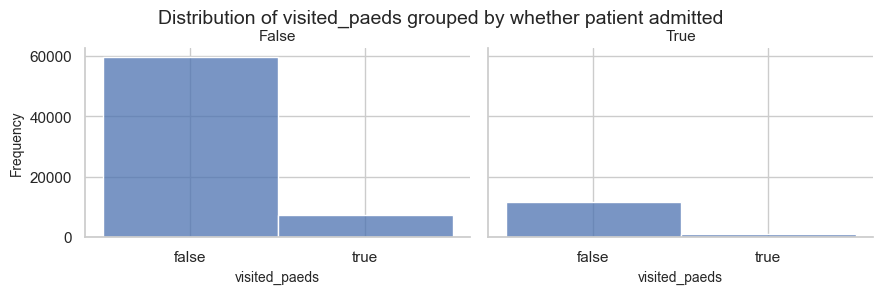

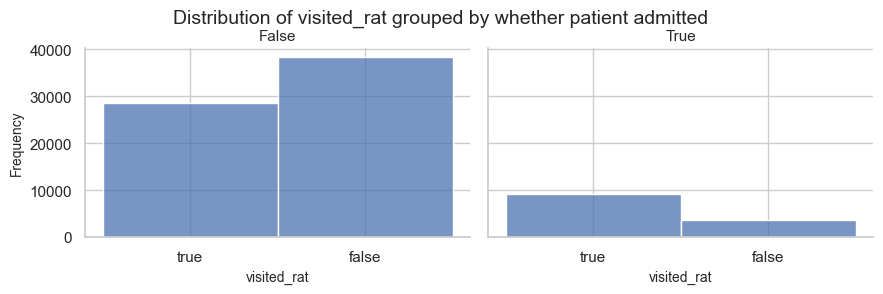

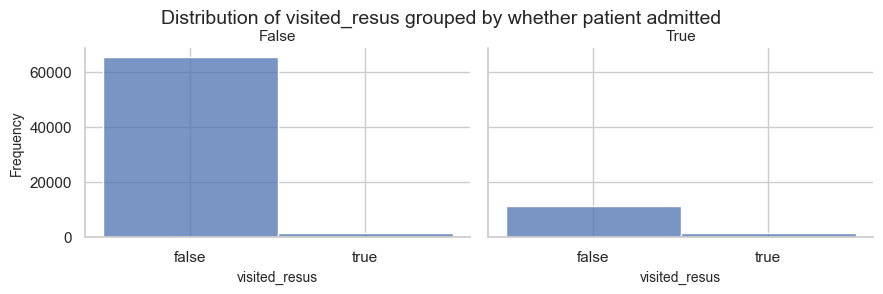

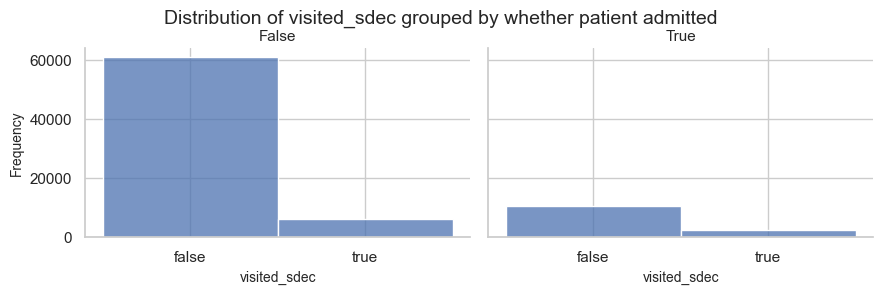

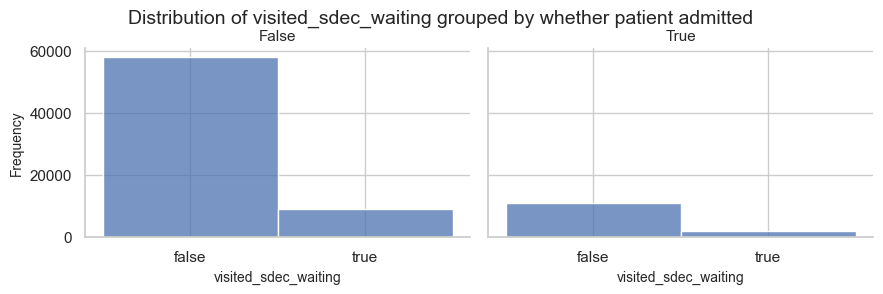

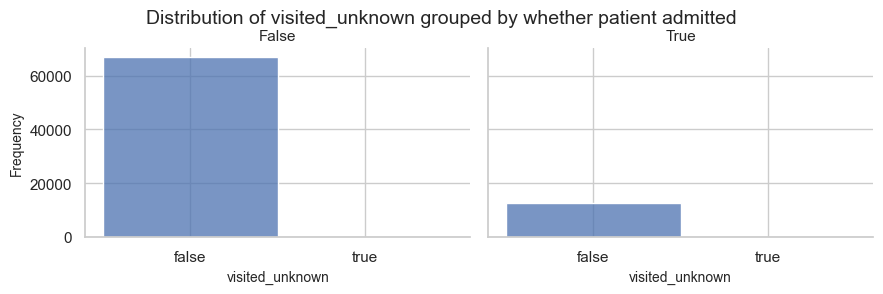

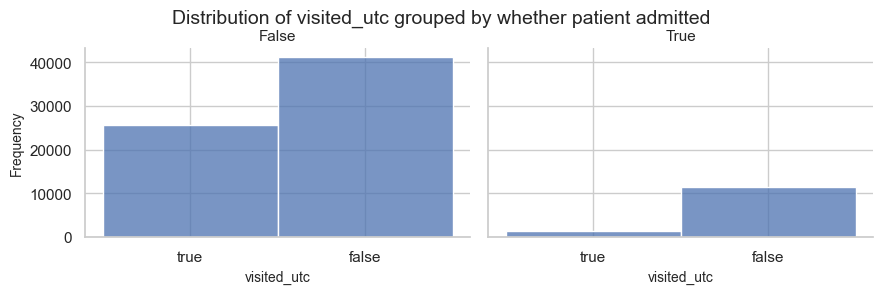

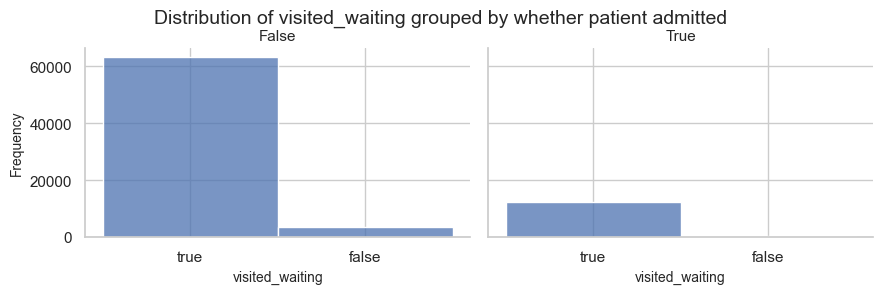

In [97]:
for col_name in dict_cols['location'][1:]:
    plot_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist')

### Observations variables

In [98]:
dict_cols['observations']

['num_obs_blood_pressure',
 'num_obs_pulse',
 'num_obs_air_or_oxygen',
 'num_obs_glasgow_coma_scale_best_motor_response',
 'num_obs_level_of_consciousness',
 'num_obs_news_score_result',
 'num_obs_manchester_triage_acuity',
 'num_obs_objective_pain_score',
 'num_obs_subjective_pain_score',
 'num_obs_temperature',
 'num_obs_oxygen_delivery_method',
 'num_obs_pupil_reaction_right',
 'num_obs_oxygen_flow_rate',
 'num_obs_uclh_sskin_areas_observed',
 'latest_obs_pulse',
 'latest_obs_respirations',
 'latest_obs_level_of_consciousness',
 'latest_obs_news_score_result',
 'latest_obs_manchester_triage_acuity',
 'latest_obs_objective_pain_score',
 'latest_obs_temperature']

First plotting the variables that count the number of times something was recorded. 

#### Count variables

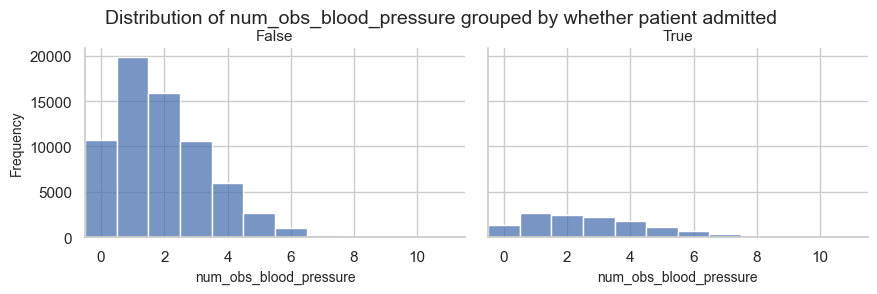

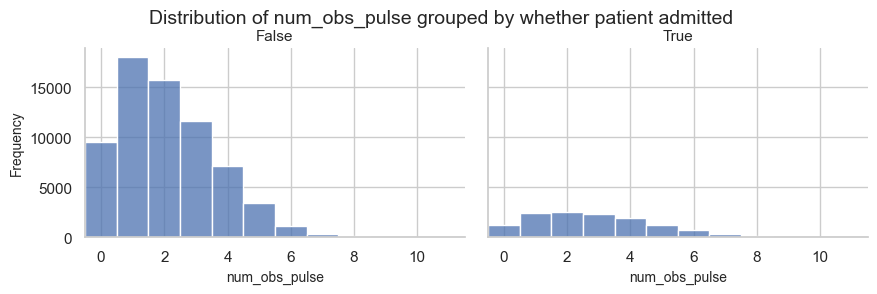

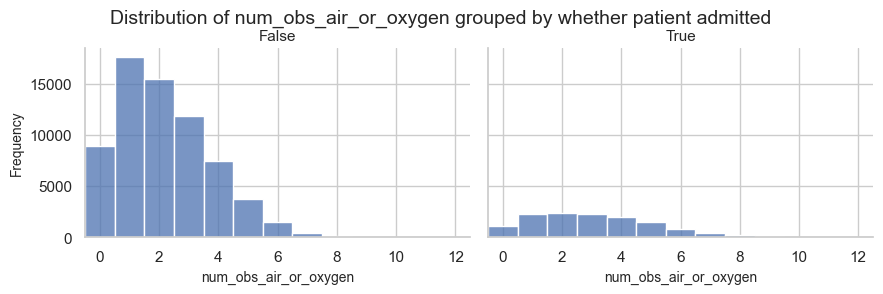

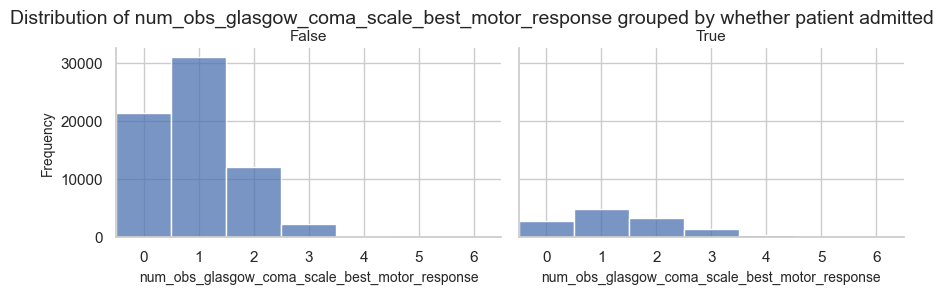

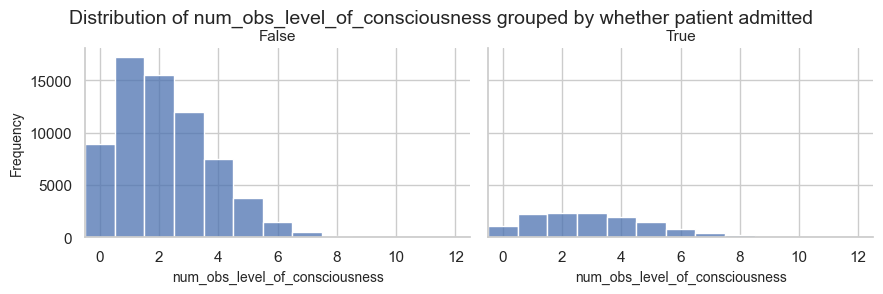

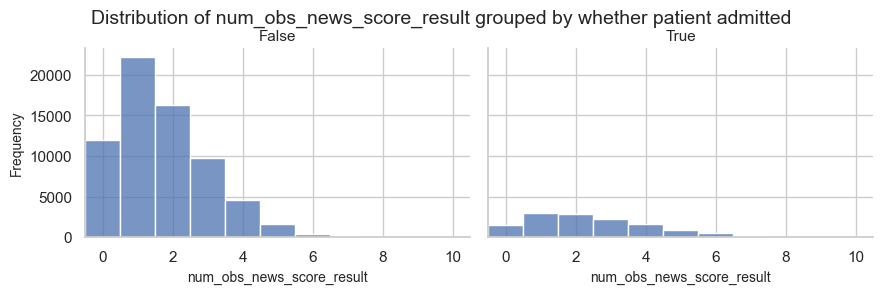

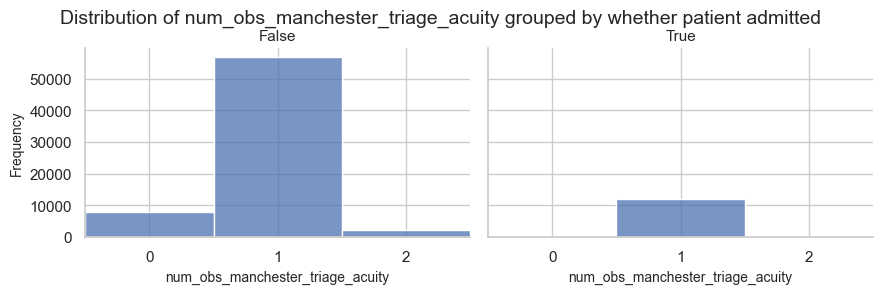

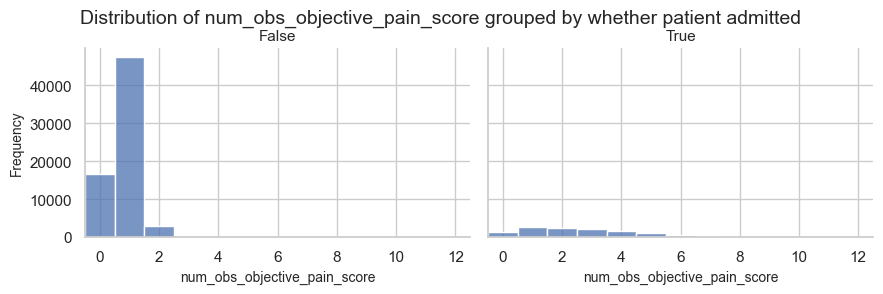

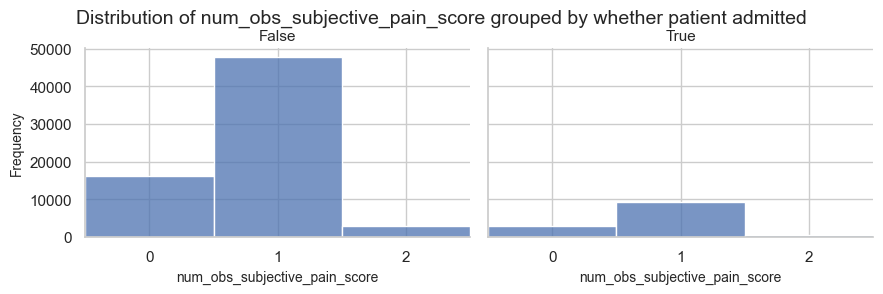

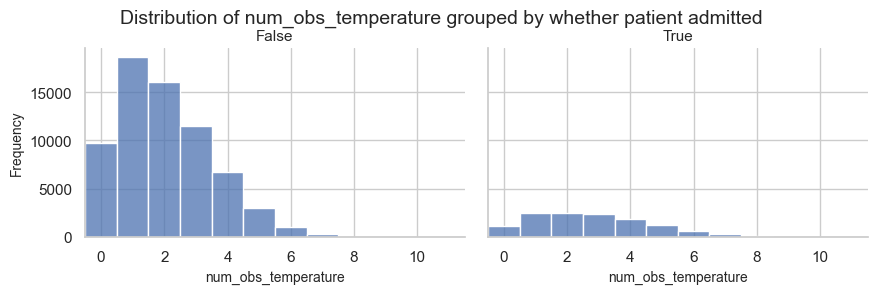

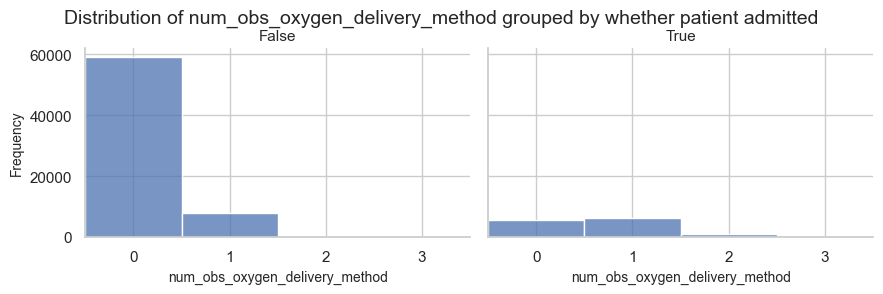

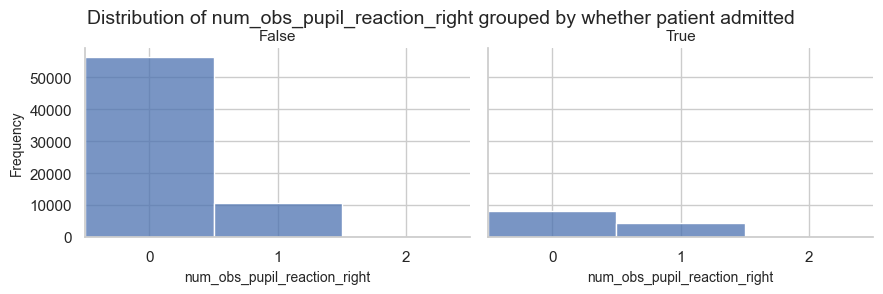

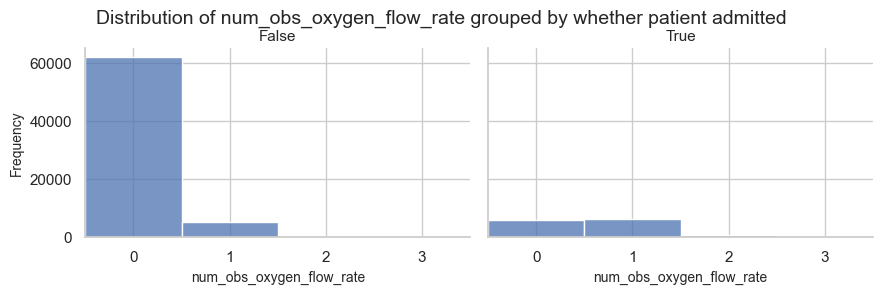

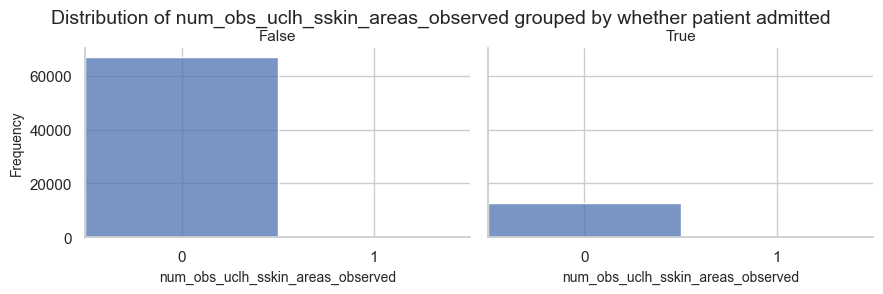

In [99]:
for col_name in [item for item in dict_cols['observations'] if str(item).startswith('num')]:
    plot_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist', is_discrete = True)



Although the charts above are not formatted to show it, there are some higher values on some of these variables, for example:

#### News Scores and Manchester Triage score values

News Scores are commonly used to track the acuity of a patient, and Manchester Triage scores are used at the door of the ED to prioritise patients

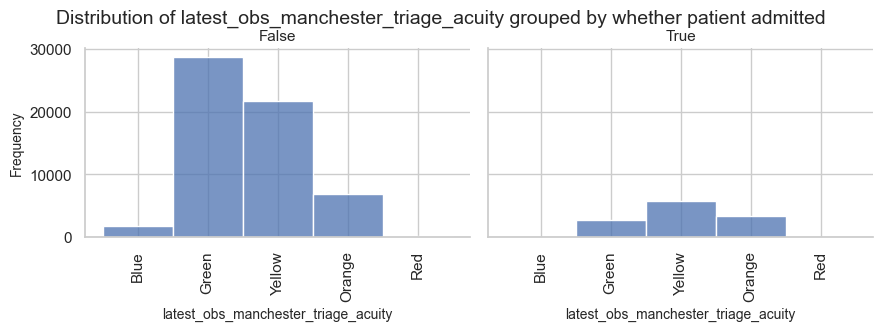

In [100]:
for col_name in [item for item in dict_cols['observations'] if ('manchester' in str(item) ) and str(item).startswith('latest')]:
    plot_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist', rotate_x_labels = True, ordinal_order=ordinal_mappings['latest_obs_manchester_triage_acuity'])

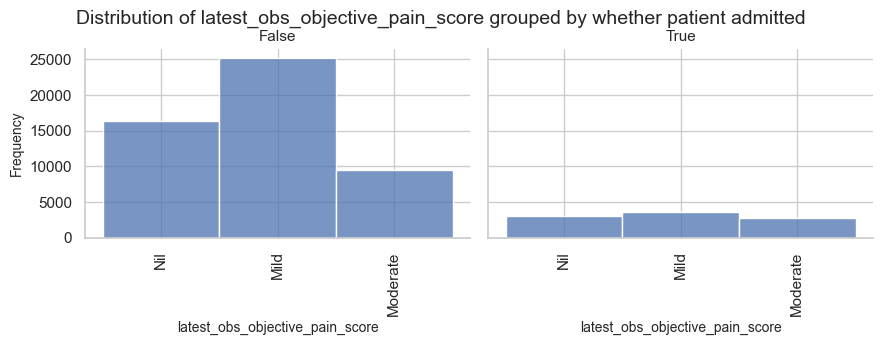

In [101]:
plot_distributions(ed_visits, 'latest_obs_objective_pain_score', 'is_admitted', 'whether patient admitted', plot_type='hist', rotate_x_labels = True, ordinal_order=ordinal_mappings['latest_obs_objective_pain_score'])


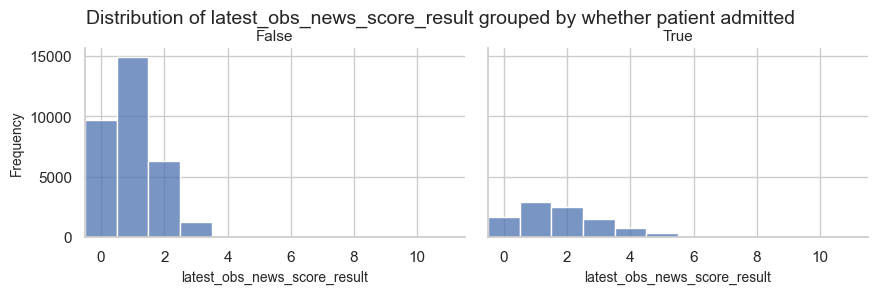

In [102]:

for col_name in [item for item in dict_cols['observations'] if 'news' in str(item) and str(item).startswith('latest')]:
    plot_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist', is_discrete = True)

The ACVPU score is commonly used to track states of consciousness

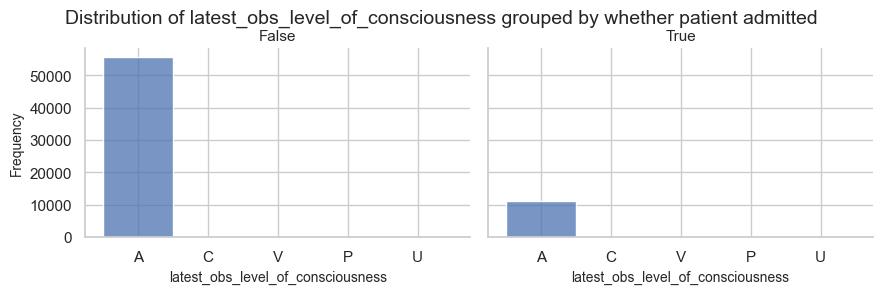

In [103]:
for col_name in [item for item in dict_cols['observations'] if 'consciousness' in str(item) and str(item).startswith('latest')]:
    plot_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist', ordinal_order=ordinal_mappings['latest_obs_level_of_consciousness'])

/Users/zellaking/Repos/patientflow/src/patientflow/viz/distribution_plots.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Parameters


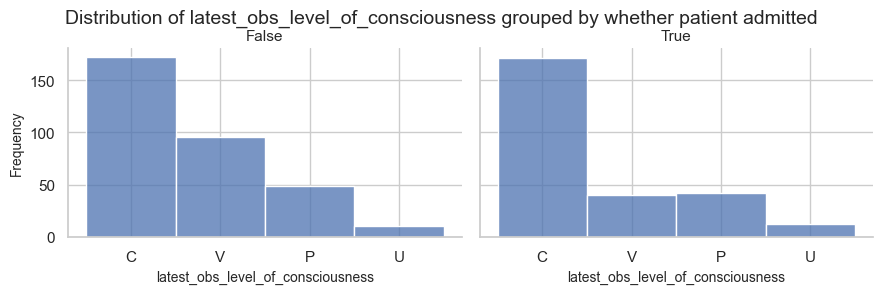

In [104]:
for col_name in [item for item in dict_cols['observations'] if 'consciousness' in str(item) and str(item).startswith('latest')]:
    plot_distributions(ed_visits[~(ed_visits.latest_obs_level_of_consciousness == 'A')], col_name, 'is_admitted', 'whether patient admitted', plot_type='hist', ordinal_order=ordinal_mappings['latest_obs_level_of_consciousness'])

#### Vital signs values

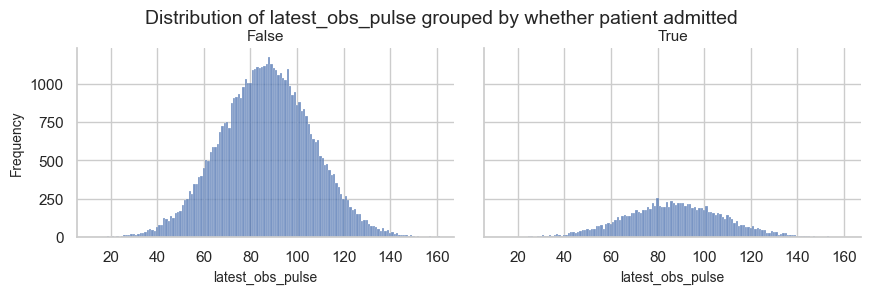

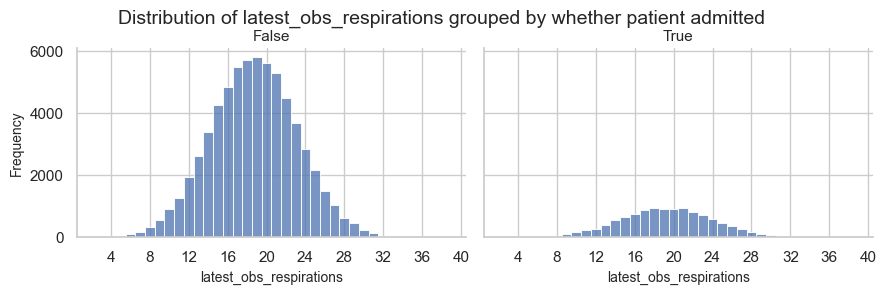

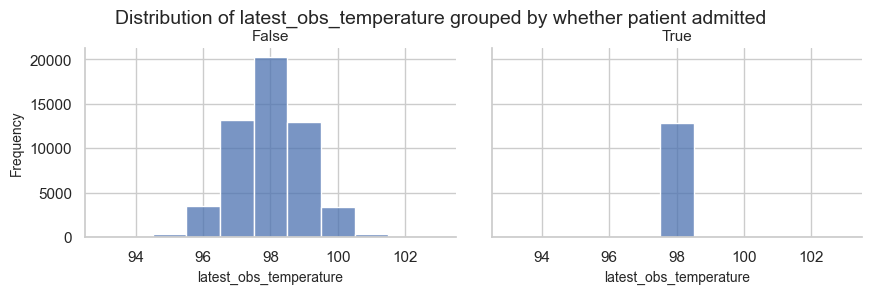

In [108]:
for col_name in [item for item in dict_cols['observations'] if str(item).startswith('latest') and ('pulse' in str(item) or 'resp' in str(item) or 'temp' in str(item))]:
    plot_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist', is_discrete = True)

### Lab variables

In [72]:
dict_cols['lab orders and results']

['lab_orders_bc',
 'lab_orders_bon',
 'lab_orders_crp',
 'lab_orders_csnf',
 'lab_orders_ddit',
 'lab_orders_ncov',
 'lab_orders_rflu',
 'lab_orders_xcov',
 'latest_lab_results_crea',
 'latest_lab_results_hctu',
 'latest_lab_results_k',
 'latest_lab_results_lac',
 'latest_lab_results_na',
 'latest_lab_results_pco2',
 'latest_lab_results_ph',
 'latest_lab_results_wcc',
 'latest_lab_results_alb',
 'latest_lab_results_htrt']

#### Lab orders

It is notable in the charts below, which show whether a lab battery was ordered, that battery CRP (for markers of inflammation) is very commonly ordered for admitted patients; in fact the majority of admitted patients have this lab battery order, whereas a minority of non-admitted patients do not. This difference between admitted and non-admitted (where the majority of admitted have something while the majority of discharged patients do not) only applies to this lab battery order. 

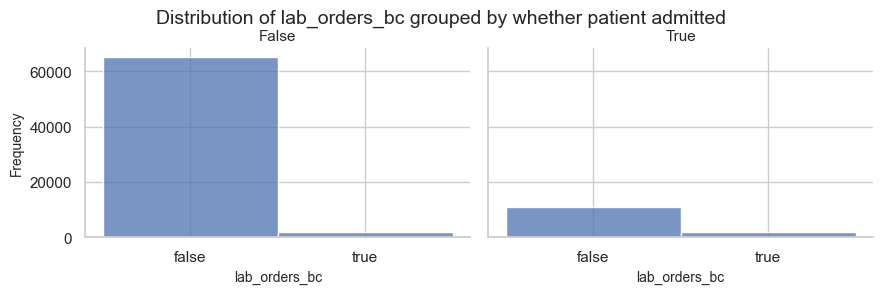

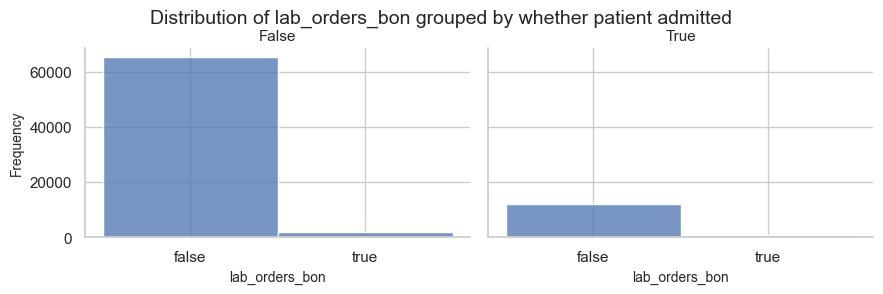

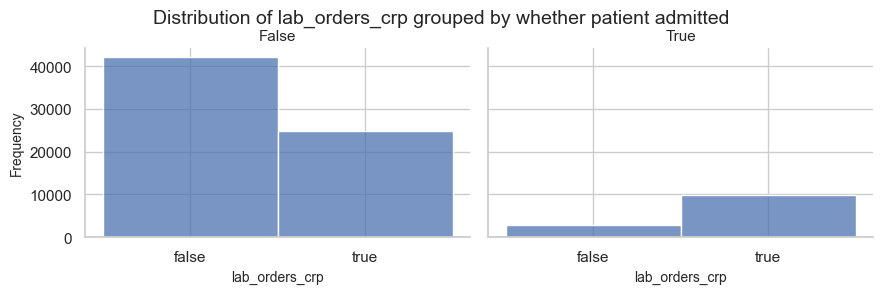

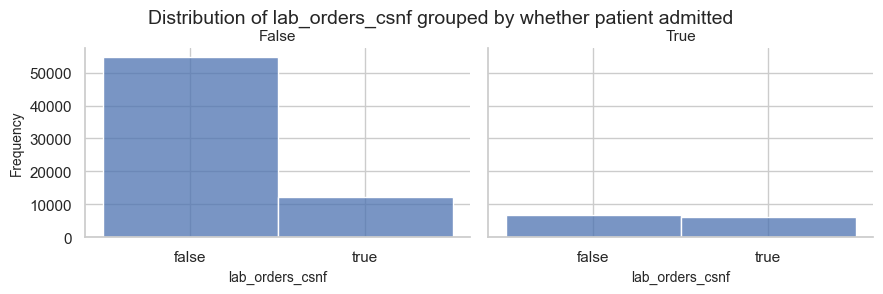

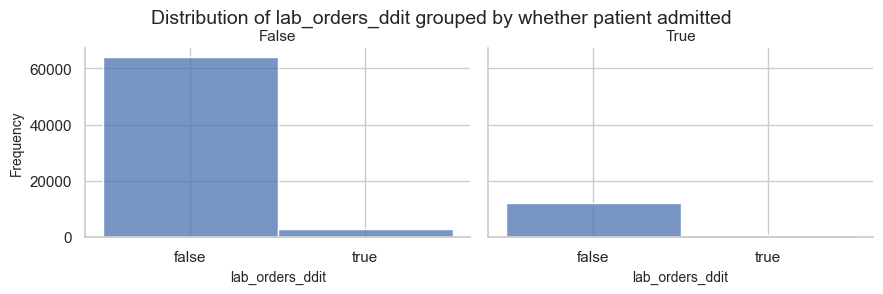

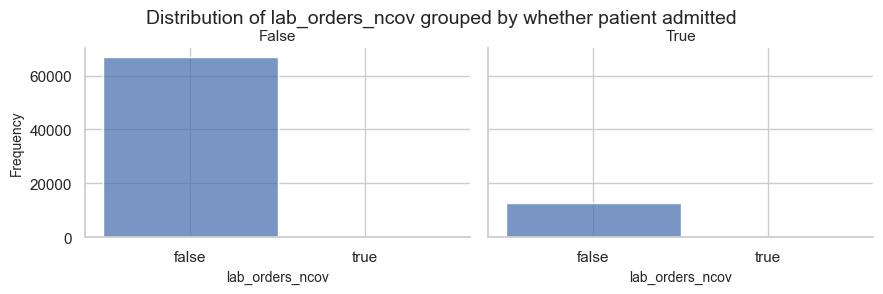

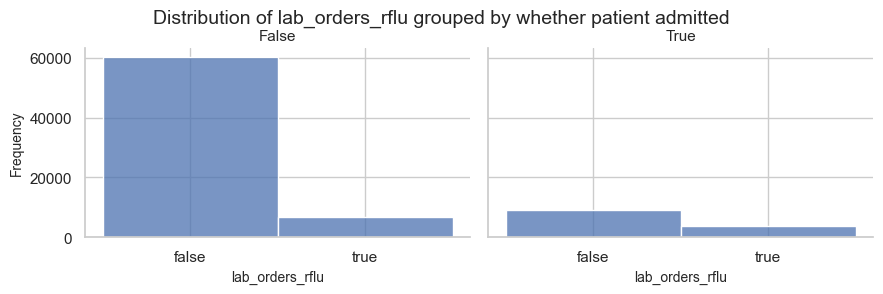

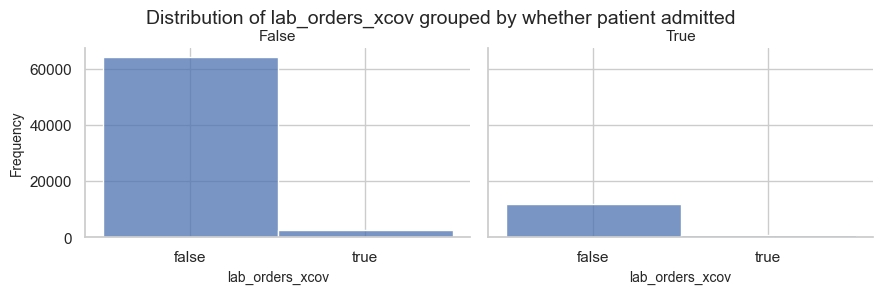

In [135]:
for col_name in [item for item in dict_cols['lab orders and results'] if str(item).startswith('lab') ]:
    plot_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist')

#### Lab results

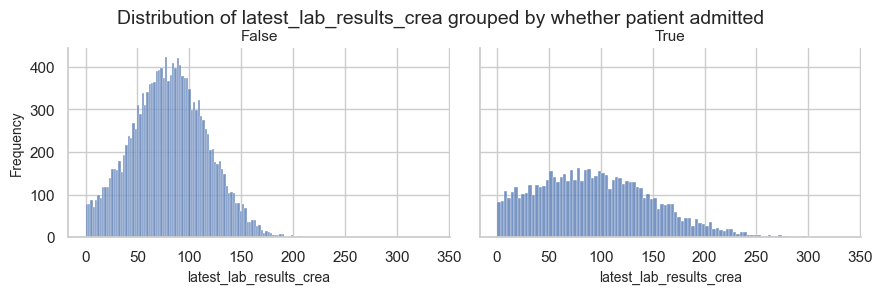

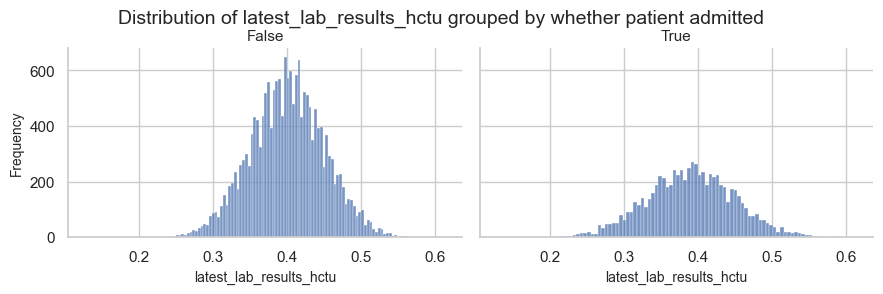

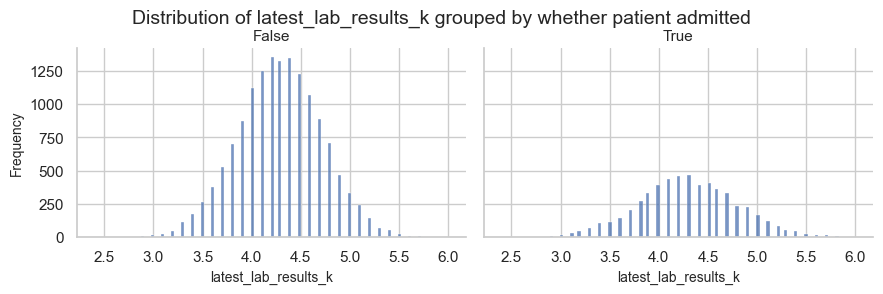

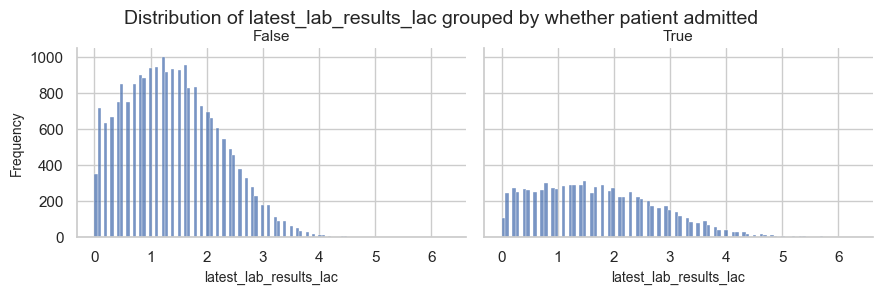

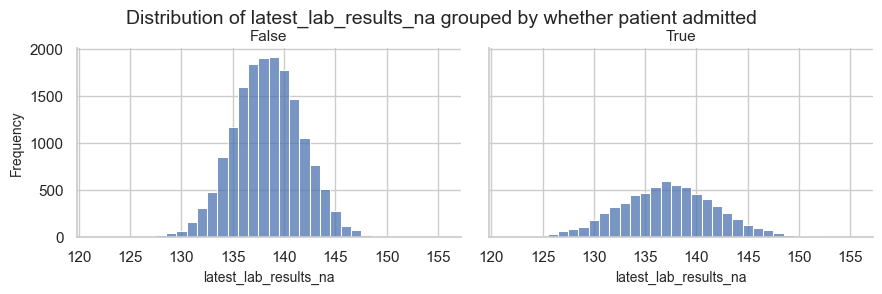

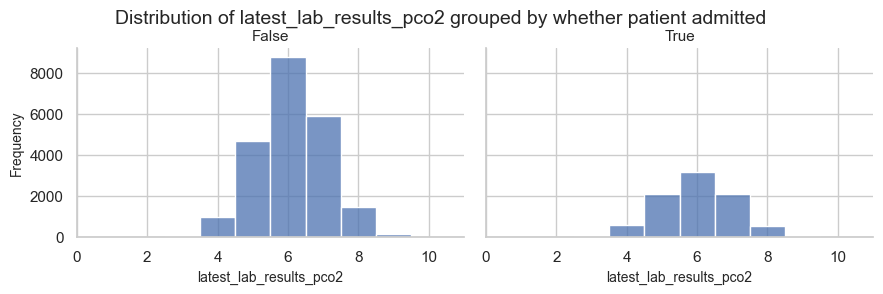

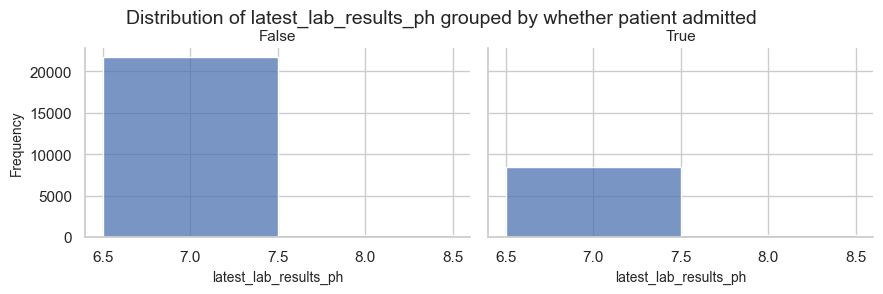

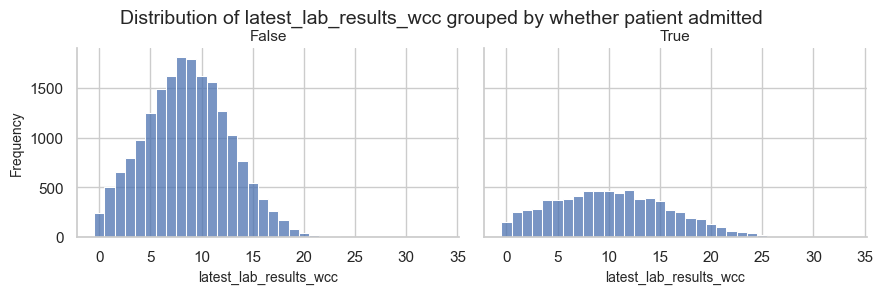

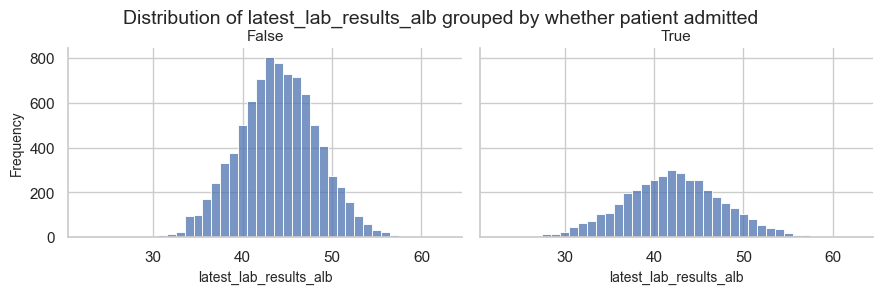

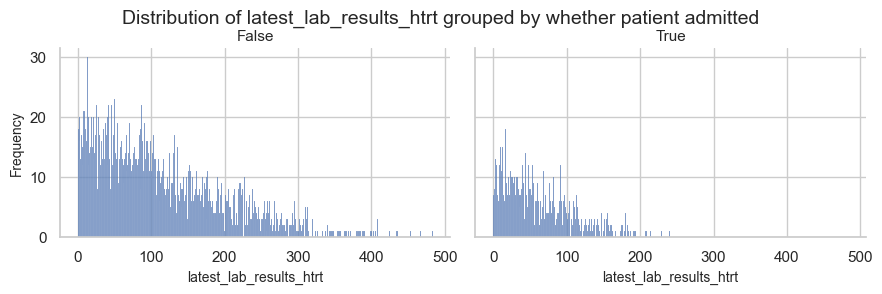

In [134]:
for col_name in [item for item in dict_cols['lab orders and results'] if str(item).startswith('latest') ]:
    plot_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist')

### Consults variables

In [111]:
dict_cols['consults']


['has_consultation', 'consultation_sequence', 'final_sequence', 'specialty']

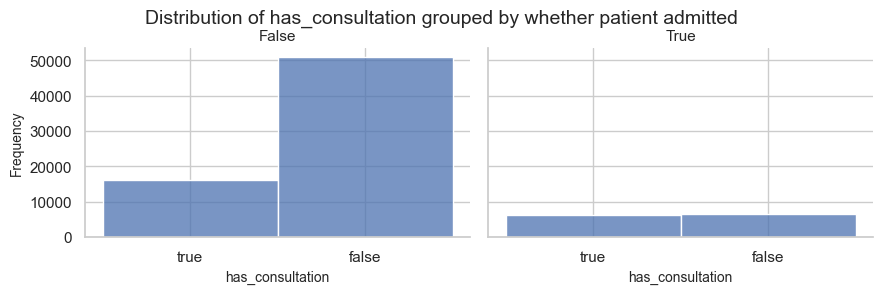

In [131]:
plot_distributions(ed_visits, 'has_consultation', 'is_admitted', 'whether patient admitted', plot_type='hist')

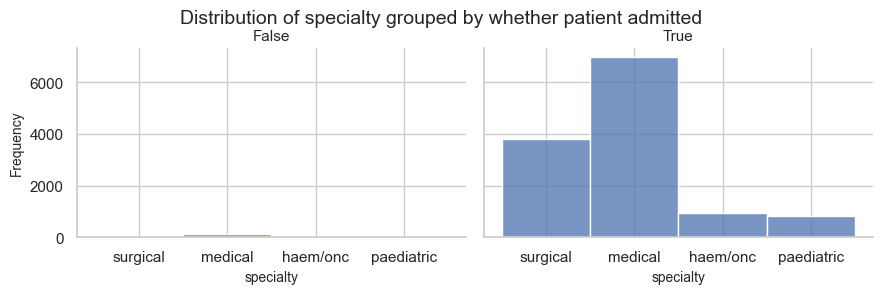

In [113]:
plot_distributions(ed_visits, 'specialty', 'is_admitted', 'whether patient admitted', plot_type='hist')

## Explore inpatient arrivals dataset

In [132]:
inpatient_arrivals.head()

,training_validation_test,arrival_datetime,sex,specialty,is_child,is_admitted
0,train,03/01/2031 05:12:49,F,medical,true,True
1,train,03/01/2031 04:54:25,F,medical,false,True
2,train,03/01/2031 21:13:25,M,haem/onc,false,True
3,train,03/01/2031 10:05:59,M,surgical,false,True
4,train,03/01/2031 10:55:40,M,medical,false,True


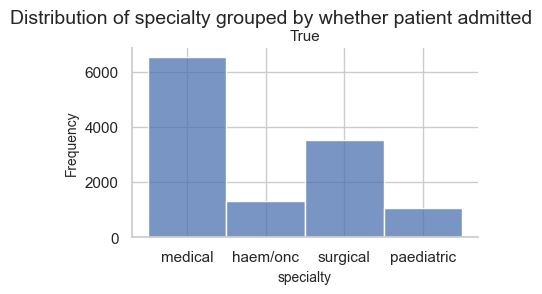

In [133]:
inpatient_arrivals['is_admitted'] = True
plot_distributions(inpatient_arrivals, 'specialty', 'is_admitted', 'whether patient admitted', plot_type='hist')

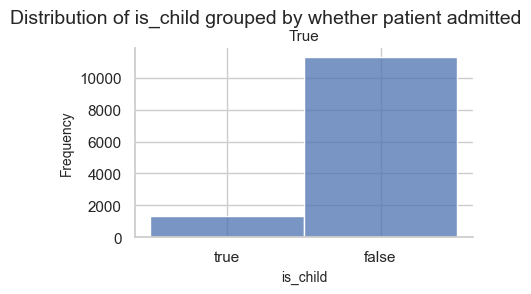

In [116]:
plot_distributions(inpatient_arrivals, 'is_child', 'is_admitted', 'whether patient admitted', plot_type='hist')

## Summary

This notebook has shown how to load files that have been provided, and shows some plots of the variables included. This is an illustrative dataset, showing the type of variables that were used for the analysis at UCLH. Other sites will have different data. 